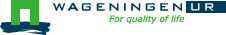



# Simulating and calibrating phenology with WOFOST

This Jupyter notebook will introduce the simulation of phenology with WOFOST. Moreover, you will attempt the estimate the important phenological parameters (TSUM1, TSUM2) by comparing observations with model predictions

Allard de Wit, August 2025

## 0. Installing the required packages

In [ ]:
!pip install pcse 

## 1. Importing the relevant modules

First the required modules need to be imported.

In [ ]:
%matplotlib inline
import sys
from pathlib import Path
import json
import yaml
from urllib.parse import quote_plus
from dotmap import DotMap
from tqdm.notebook import tqdm
import requests
import pcse
import pandas as pd
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

## 2. Reading phenological observations

The phenological observations are from an agroecological zone covering Ireland and part of the UK.

In [ ]:
url = "https://github.com/artofmodelling/phenomodelling/raw/refs/heads/main/data/pheno_obs_1784.xlsx"
cwd = Path.cwd()
fname = cwd / "pheno_obs_1784.xlsx"

r = requests.get(url)
with open(fname, 'wb') as fp:
    fp.write(r.content)
df = pd.read_excel(fname, sheet_name="data")
df_phenology_aez1784 = df[df.VALID == True]
df_phenology_aez1784.head()

## 3. Fetching weather data

The code below pre-loads the weather data. Subsequent calls will be much faster.

In [ ]:
from functools import cache
from pcse.util import wind10to2, check_date, reference_ET
from pcse.base import WeatherDataContainer, WeatherDataProvider

class AgERA5WeatherDataProvider(WeatherDataProvider):
    variable_renaming = [("temperature_max", "TMAX", None),
                         ("temperature_min", "TMIN", None),
                         ("temperature_avg",  "TEMP", None),
                         ("vapourpressure", "VAP", None),
                         ("windspeed", "WIND", wind10to2),
                         ("precipitation", "RAIN", lambda x: x/10.),
                         ("radiation", "IRRAD", lambda x: x*1000.),
                         ("snowdepth", "SNOWDEPTH", None),
                         ("day", "DAY", None)]

    def __init__(self, meteo):
        super().__init__()
        location_info = DotMap(meteo["data"]["location_info"])
        self.longitude = float(location_info.grid_agera5_longitude)
        self.latitude = float(location_info.grid_agera5_latitude)
        self.elevation = float(location_info.grid_agera5_elevation)
        df_AgERA5 = pd.DataFrame(meteo["data"]["weather_variables"])

        if len(df_AgERA5) == 0:
            raise RuntimeError("No AgERA5 data found for this location and/or date range")

        # Rename columns and apply unit corrections
        rename_cols = {old_name:new_name for old_name, new_name, conversion in self.variable_renaming}
        convert_cols = {new_name:conversion for old_name, new_name, conversion in
                        self.variable_renaming if conversion is not None}
        df_AgERA5 = df_AgERA5.rename(columns=rename_cols)
        for column, conv in convert_cols.items():
            df_AgERA5[column] = df_AgERA5[column].apply(conv)

        for row in df_AgERA5.itertuples(index=False):
            self._make_WeatherDataContainer(row._asdict())

    def _make_WeatherDataContainer(self, daily_weather):

        daily_weather.update({"LAT": self.latitude, "LON": self.longitude, "ELEV": self.elevation})
        # update Fake ET values for this example
        daily_weather.update({"E0": 1., "ES0": 1., "ET0": 1.})

        # Build weather data container from dict 't'
        wdc = WeatherDataContainer(**daily_weather)

        # add wdc to dictionary for thisdate
        self._store_WeatherDataContainer(wdc, daily_weather["DAY"])

@cache
def get_weatherdata(rec):
    url = f"https://raw.githubusercontent.com/artofmodelling/phenomodelling/refs/heads/main/data/meteo/{rec.ObjectID}.json"
    json_response = requests.get(url).json()
    wdp =  AgERA5WeatherDataProvider(json_response)
    return wdp

for row in tqdm(df_phenology_aez1784.itertuples(), total=len(df_phenology_aez1784)):
    wdp = get_weatherdata(row)

## 4. Defining agromanagement

The code below defines the agromanagement structure. Results are also cached to speed up the computations

In [ ]:
@cache
def get_agromanagement(rec):
    if pd.isna(rec.DOS) and pd.isna(rec.DOE):
        raise RuntimeError(f"No sowing or emergence date for {rec.ObjectID}")
    elif not pd.isna(rec.DOS):
        start_date = rec.DOS.date()
        start_type = "sowing"
    else:
        start_date = rec.DOE.date()
        start_type = "emergence"
        
    agro_yaml = f"""
- {start_date}:
    CropCalendar:
        crop_name: barley
        variety_name: Spring_barley_301
        crop_start_date: {start_date}
        crop_start_type: {start_type}
        crop_end_date:
        crop_end_type: maturity
        max_duration: 300
    TimedEvents:
    StateEvents:
    """
    agro = yaml.safe_load(agro_yaml)
    return agro

for row in tqdm(df_phenology_aez1784.itertuples(), total=len(df_phenology_aez1784)):
    agro = get_agromanagement(row)

## 5. Defining crop parameters

In [ ]:
from pcse.base import ParameterProvider
from pcse.input import YAMLCropDataProvider

cropd = YAMLCropDataProvider()
params = ParameterProvider(cropdata=cropd)

## 6. Running the crop phenology model

The code below runs the phenology model for all points where we have observations in order to make a prediction of anthesis and maturity dates. It uses the given TSUM1 and TSUM2 as parameters for the prediction.

Note that you can change the values of TSUM1/2 to improve the prediction

In [ ]:
from pcse.models import Wofost72_Phenology
TSUM1 = 600
TSUM2 = 700

results = []
for row in  tqdm(df_phenology_aez1784.itertuples(), total=len(df_phenology_aez1784)):
    wdp = get_weatherdata(row)
    agro = get_agromanagement(row)
    params.set_override("TSUM1", TSUM1, check=False)
    params.set_override("TSUM2", TSUM1, check=False)
    wofost = Wofost72_Phenology(params, wdp, agro)
    wofost.run_till_terminate()
    output = wofost.get_summary_output()[0]
    output["ObjectID"] = row.ObjectID
    results.append(output)
df_wofost_results = pd.DataFrame(results)

## 6. Process simulated results
We need to do some processing on the model output. For example we need to convert date datatypes and compute the number of days between sowing and anthesis/maturity.

In [ ]:
selected_columns = ["DOS","DOE","DOA","DOM"]
df_pheno_sim = df_wofost_results.set_index("ObjectID")[selected_columns]
for column in selected_columns:
    df_pheno_sim[column] = pd.to_datetime(df_pheno_sim[column])
df_pheno_sim["days2anthesis"] = (df_pheno_sim.DOA - df_pheno_sim.DOS).dt.days
df_pheno_sim["days2maturity"] = (df_pheno_sim.DOM - df_pheno_sim.DOS).dt.days
df_pheno_sim.head()

## 7. Process observed data
We need to do some similar processing on the observations. Moreover, there are many observations of harvest but only a few of maturity. Therefore we estimated maturity from harvest by subtracting 7 days. Here we assume that farmers harvest their crop 7 days after maturity. This is a rough estimate and in practice it depends on all kind of factors: crop type, weather conditions, availability of labour and machinery, etc.

In [ ]:
df_pheno_obs = df_phenology_aez1784.set_index("ObjectID")
df_pheno_obs = df_pheno_obs[["DOS","DOA","DOM","DOH"]]
# Estimate maturity from harvest if DOM is null
days_to_harvest = 7
ix = pd.isna(df_pheno_obs.DOM)
df_pheno_obs.loc[ix, "DOM"] = df_pheno_obs.loc[ix,"DOH"] - pd.Timedelta(days_to_harvest, unit="days")
df_pheno_obs["days2anthesis"] = (df_pheno_obs.DOA - df_pheno_obs.DOS).dt.days
df_pheno_obs["days2maturity"] = (df_pheno_obs.DOM - df_pheno_obs.DOS).dt.days
df_pheno_obs.head()

## 8. Plot observations against predictions
Here we plot the simulated number of days to anthesis and maturity against the observations. 

What do you conclude and can you do better?

In [ ]:
fig, axes = plt.subplots(figsize=(8,8))
ix = pd.isna(df_pheno_obs.days2anthesis)
axes.scatter(df_pheno_obs[~ix].days2anthesis, df_pheno_sim[~ix].days2anthesis, label="Days2Anthesis", color='blue', marker="o")
ix = pd.isna(df_pheno_obs.days2maturity)
axes.scatter(df_pheno_obs[~ix].days2maturity, df_pheno_sim[~ix].days2maturity, label="Days2Maturity", color='orange', marker="o")
limits = [40, 200]
axes.set_xlabel("Observed days to stage")
axes.set_ylabel("Simulated days to stage")
axes.set_xlim(limits)
axes.set_ylim(limits)
axes.plot(limits, limits, marker="", linestyle="--", color='black')
r = fig.legend(loc=2)


In [ ]:
df_pheno_obs